In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

# EMS Stations Data for Indiana, with Indiana map

In [2]:
us_states = "data/map_data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
police_raw = pd.read_csv("data/map_data/indiana-police-stations.csv")
fire_raw = pd.read_csv("data/map_data/indiana-fire-stations.csv")

In [3]:
def getPoints(df):
    df = df["WKT"].str.strip("POINT (")
    df = df.str.strip(")")
    df = df.str.split(" ",expand=True)
    df = GeoDataFrame(df,geometry=[Point(xy) for xy in zip(df[0], df[1])])
    return df

In [4]:
police_pts = getPoints(police_raw)
fire_pts = getPoints(fire_raw)

In [7]:
len(fire_pts)

1001

In [5]:
IN_basemap = gpd.read_file(us_states)
IN_basemap = IN_basemap[IN_basemap['NAME']=="Indiana"]

In [6]:
IN_basemap.crs = {"init":"epsg:4326"} # WGS84 (EPSG: 4326), Universal geographic coordinate system (latitude and longitude)
IN_basemap = IN_basemap.to_crs(epsg=3857) # WEB MERCATOR (EPSG: 3857), Widely accepted projection, in meters
police_pts.crs = {"init":"epsg:4326"} # WGS84 (EPSG: 4326), Universal geographic coordinate system (latitude and longitude)
police_pts = police_pts.to_crs(epsg=3857) # WEB MERCATOR (EPSG: 3857), Widely accepted projection, in meters
fire_pts.crs = {"init":"epsg:4326"} # WGS84 (EPSG: 4326), Universal geographic coordinate system (latitude and longitude)
fire_pts = fire_pts.to_crs(epsg=3857) # WEB MERCATOR (EPSG: 3857), Widely accepted projection, in meters

C:\Users\jatin\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


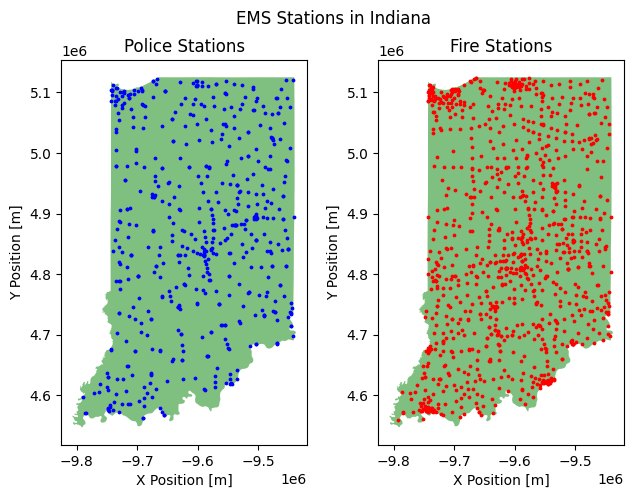

In [7]:
fig, (axl,axr) = plt.subplots(1,2)
fig.set_size_inches(7.5,5)
IN_basemap.plot(ax=axl,color='green',alpha=0.5)
IN_basemap.plot(ax=axr,color='green',alpha=0.5)
police_pts.plot(ax=axl,color='blue',markersize=3)
fire_pts.plot(ax=axr,color='red',markersize=3)
axl.set_title("Police Stations")
axl.set_xlabel("X Position [m]")
axl.set_ylabel("Y Position [m]")
axr.set_title("Fire Stations")
axr.set_xlabel("X Position [m]")
axr.set_ylabel("Y Position [m]")
fig.suptitle("EMS Stations in Indiana")
plt.show()

<hr>

# Indiana map with county subdivisions, along with county center points</h1>

In [8]:
IN_counties = "data/map_data/us-county-boundaries/us-county-boundaries.shp"
IN_county_geo = gpd.read_file(IN_counties,crs=4326) 
IN_county_geo = IN_county_geo[['name','intptlat','intptlon','geometry','aland']] # land area is in m^2
IN_county_geo=IN_county_geo.set_index('name')

In [9]:
county_centers = IN_county_geo[['intptlat','intptlon']].copy()
county_centers['intptlat'] = county_centers['intptlat'].str.strip("+")
county_centers = GeoDataFrame(county_centers,geometry=[Point(xy) for xy in zip(county_centers['intptlon'], county_centers['intptlat'])],crs=4326)
county_centers = county_centers.to_crs(epsg=3857) 

Text(0.5, 1.0, 'Indiana Counties with Geographic Centers')

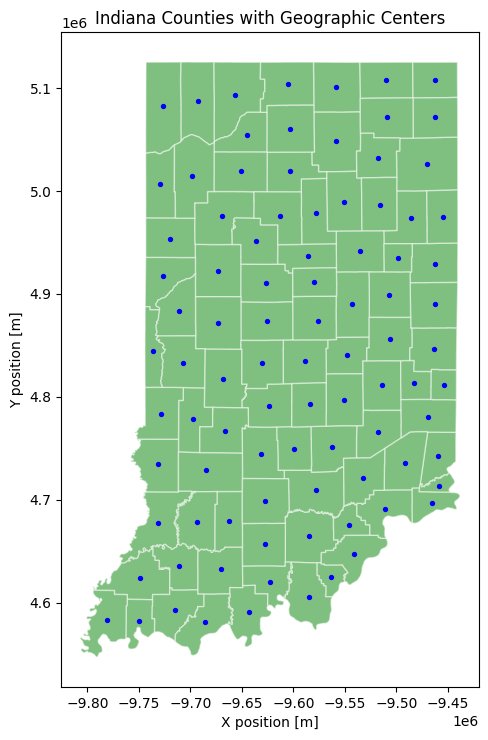

In [10]:
IN_county_geo = IN_county_geo.to_crs(epsg=3857)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8.5)
IN_county_geo.plot(ax=ax,alpha=0.5,color='green',edgecolor='1.0')
county_centers.plot(ax=ax,color='blue',markersize=8)
ax.set_xlabel("X position [m]")
ax.set_ylabel("Y position [m]")
ax.set_title("Indiana Counties with Geographic Centers")

<hr>

# Mapping Counties to OD counts

In [11]:
od_files=["data_2016.csv","data_2017.csv","data_2018.csv","data_2019.csv"]
years = [name.split(".csv")[0].split("_")[1] for name in od_files]
od_prefix = "data/overdose_data/"
od_filenames = [od_prefix + prefix for prefix in od_files]

In [12]:
od_dfs = []
for file in od_filenames:
    df = pd.read_csv(file)
    df = df.rename(columns={"geog_name":"county","geog_type":"od_count"})
    df = df[['county','od_count']]
    df = df.set_index('county')
    df = df.drop(index='INDIANA')
    df = pd.concat([df,IN_county_geo],axis=1)
    df = GeoDataFrame(df)
    df = df.rename_axis('county')
    od_dfs.append(df)

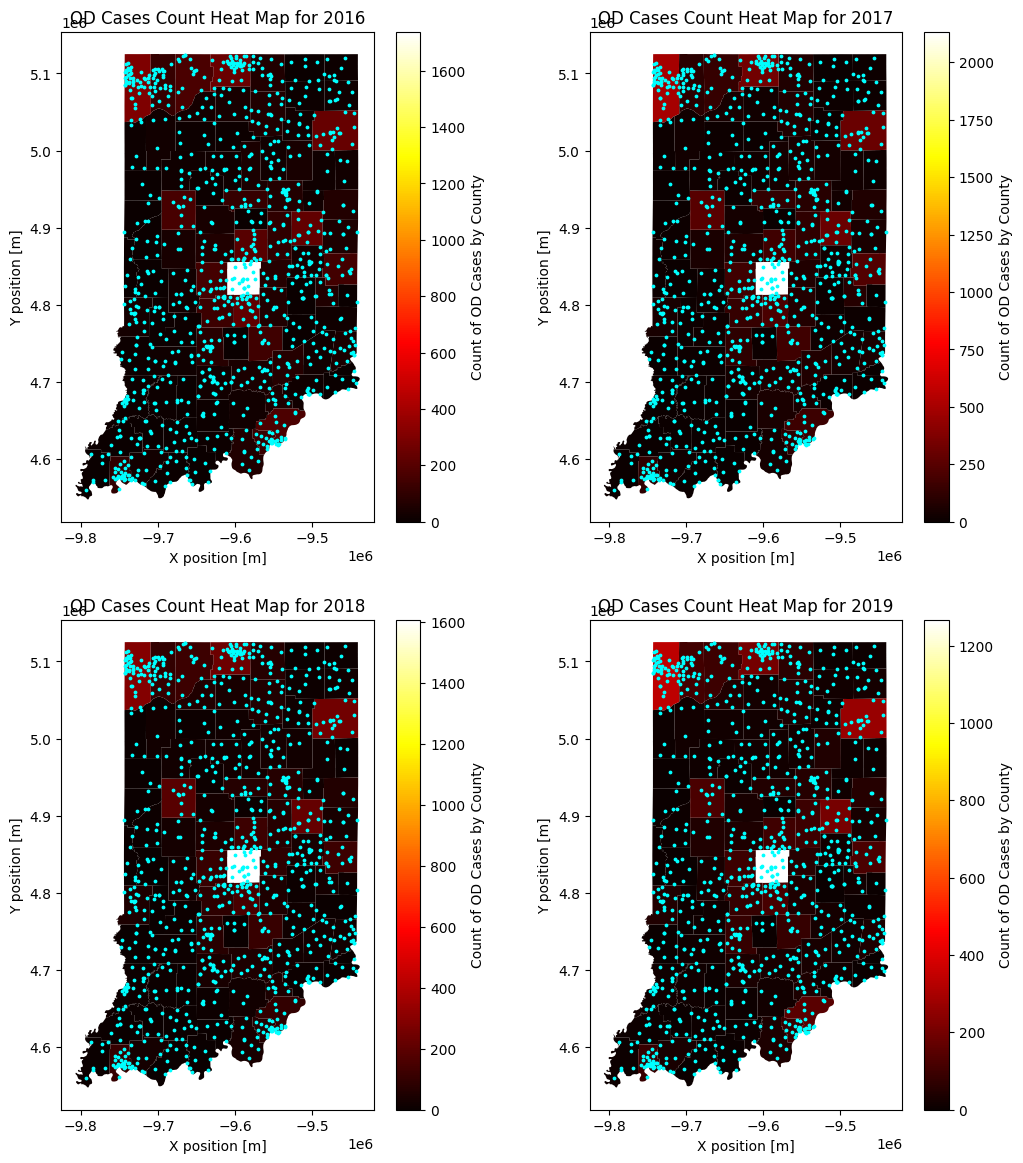

In [13]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(12.5,14)
#fig.suptitle("OD Cases Each Year per County and Fire Stations")
axs = [ax for sublist in axs for ax in sublist]
for ax,df,year in zip(axs,od_dfs,years):
    df.plot(ax=ax,column='od_count',cmap='hot',legend=True,
                   legend_kwds={'label': "Count of OD Cases by County"})
    fire_pts.plot(ax=ax,color='cyan',markersize=3)
    ax.set_xlabel("X position [m]")
    ax.set_ylabel("Y position [m]")
    ax.set_title("OD Cases Count Heat Map for "+year);
fig.savefig("data/overdose_data/OD_Cases_HeatMaps")

In [14]:
# polygon.contains or point.within

<h4>Example of Drawing circle with specified x-y and range</h4>

In [15]:
import matplotlib.collections as collections
import numpy as np

Adding patches in a loop..... slow method

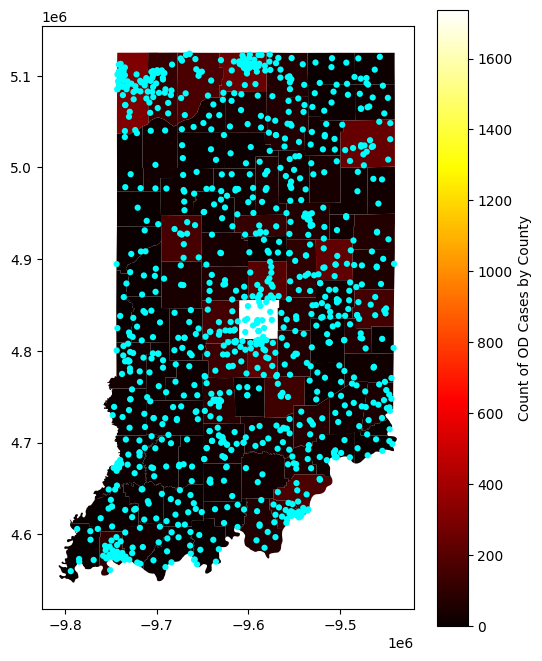

In [16]:
radius = 3.4e3 #3.4 km, based on 40mph cruise velocity
fig,ax = plt.subplots(1,1)
fig.set_size_inches(6,8)
#cir = patches.Circle(Point((-9.6e6,4.85e6)),1e5,fc='green')
od_dfs[0].plot(ax=ax,column='od_count',cmap='hot',legend=True,
                   legend_kwds={'label': "Count of OD Cases by County"})

for x,y in zip(fire_pts['geometry'].x,fire_pts['geometry'].y):
    cir = patches.Circle((x,y),radius,fc='cyan')
    ax.add_patch(cir)

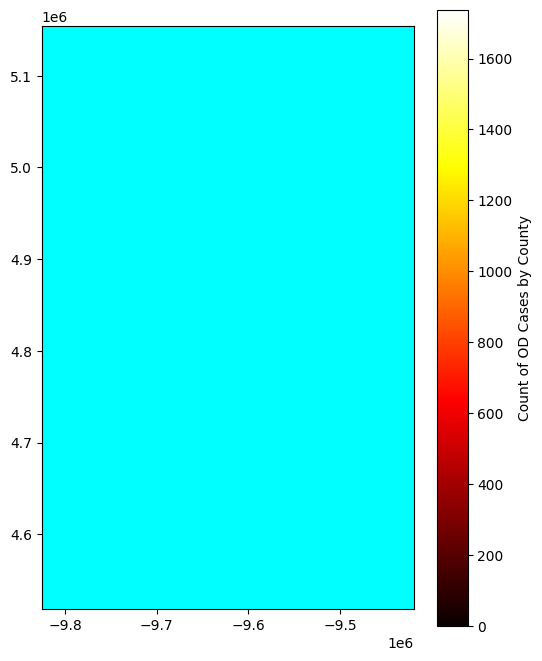

In [17]:
radius = 3.4 #3.4 km
fig,ax = plt.subplots(1,1)
fig.set_size_inches(6,8)
od_dfs[0].plot(ax=ax,column='od_count',cmap='hot',legend=True,
                   legend_kwds={'label': "Count of OD Cases by County"})
trad = ax.transData.transform((radius,0))[0]
size = np.pi*trad**2
sizes = np.full((len(fire_pts)),size)

ptss = np.array([fire_pts['geometry'].x,fire_pts['geometry'].y]).transpose()
cirs = collections.CircleCollection(sizes,offsets = ptss,transOffset=ax.transData,color='cyan')
#cirs= []
#for x,y in zip(fire_pts['geometry'].x,fire_pts['geometry'].y):
    #cir = patches.Circle((x,y),radius,fc='cyan')
    #cirs.append(cir)
    
ax.add_collection(cirs)
plt.show()
#ax.add_patch(cir)

<hr>

# Computing (Best Case) Land Coverage Based on Num. of Stations and Land Area

In [18]:
stationsPerCounty = []
percentCovered = []
radius = 3.4e3 # m
area = np.pi*radius**2
for county_shape,county_area in zip(od_dfs[0]['geometry'],od_dfs[0]['aland']):
    stations = sum(county_shape.contains(fire_pts['geometry']))
    stationsPerCounty.append(stations)
    percentCovered.append((float(stations)*area)/float(county_area)*100)
od_dfs[0]['stations'] = stationsPerCounty
od_dfs[0]['coverage'] = percentCovered
od_dfs[0]['avgcover'] = np.average(percentCovered)

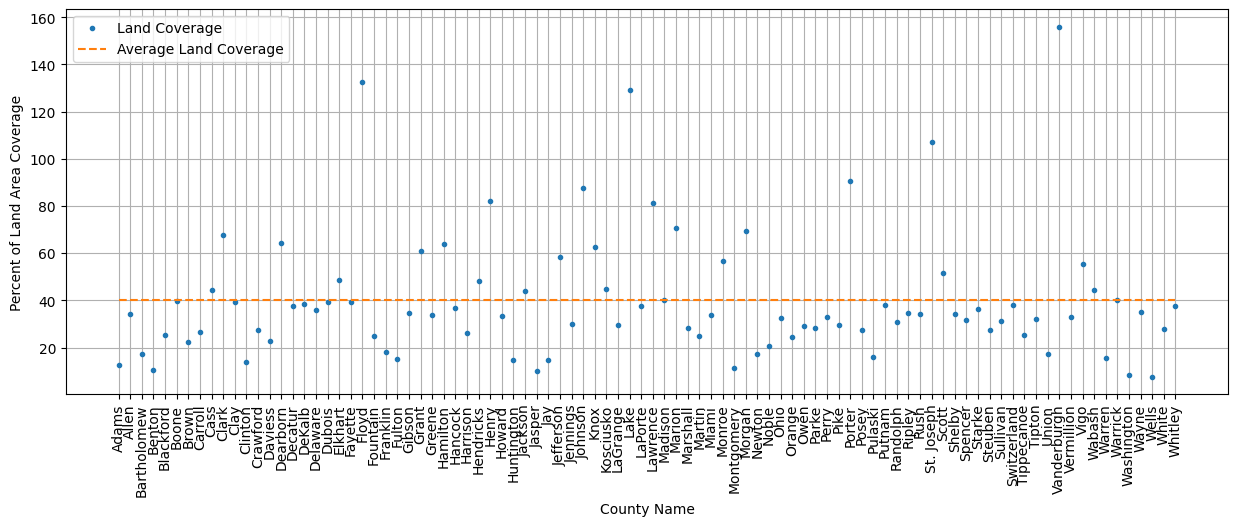

In [19]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(15,5)
ax.plot(od_dfs[0]['coverage'],'.')
ax.plot(od_dfs[0]['avgcover'],'--')
ax.tick_params(axis='x', labelrotation = 90)
plt.grid()
plt.xlabel("County Name")
plt.ylabel("Percent of Land Area Coverage")
plt.legend(["Land Coverage","Average Land Coverage"])

In [20]:
for df,yr in zip(od_dfs,years):
    df.to_file("data/saved_odDFs/Dataframe_OD_"+str(yr)+".shp")

In [21]:
od_dfs[0]

,od_count,intptlat,intptlon,geometry,aland,stations,coverage,avgcover
county,,,,,,,,
Adams,24,+40.7457327,-084.9361303,"POLYGON ((-9470194.541 4987432.387, -9470201.1...",877815499,3,12.411541,39.966785
Allen,244,+41.0919086,-085.0717907,"POLYGON ((-9483540.524 5051390.887, -9483435.1...",1702451597,16,34.131307,39.966785
Bartholomew,137,+39.2058430,-085.8979988,"POLYGON ((-9582569.341 4753145.057, -9582570.4...",1054009620,5,17.227932,39.966785
Benton,0,+40.6009394,-087.3147862,"POLYGON ((-9743374.798 4960820.438, -9743374.7...",1052616465,3,10.350440,39.966785
Blackford,22,+40.4726717,-085.3237297,"POLYGON ((-9511786.175 4935839.563, -9511789.4...",427559407,3,25.481940,39.966785
...,...,...,...,...,...,...,...,...
Washington,25,+38.6006126,-086.1047512,"POLYGON ((-9607734.670 4670871.008, -9607758.6...",1330454436,3,8.188964,39.966785
Wayne,143,+39.8630908,-085.0067351,"POLYGON ((-9484525.813 4847620.006, -9484525.8...",1040539262,10,34.901913,39.966785
Wells,16,+40.7352727,-085.2129742,"POLYGON ((-9487024.267 5000104.671, -9486733.9...",953341278,2,7.618848,39.966785
